In [53]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path

import itertools as it
import functools as fn
from tqdm import tqdm

import re
import config as cfg

In [54]:
data_path = Path('./dataset/data_df.csv')
data_df = pd.read_csv(data_path)
data_df.head()

,code1,code2,similar
0,./dataset/code/problem028/problem028_112.py,./dataset/code/problem085/problem085_1.py,0
1,./dataset/code/problem246/problem246_49.py,./dataset/code/problem246/problem246_125.py,1
2,./dataset/code/problem097/problem097_90.py,./dataset/code/problem204/problem204_26.py,0
3,./dataset/code/problem071/problem071_13.py,./dataset/code/problem071/problem071_94.py,1
4,./dataset/code/problem281/problem281_139.py,./dataset/code/problem300/problem300_109.py,0


# 전처리

In [55]:
def preprocessing(code):
    code = re.sub(r'    ',r'\t ',code)
    code = re.sub(r"#.*\n",'\n',code) # 주석제거
    code = re.sub(r"import.*\n",'',code) # 모듈 참고 안함
    code = re.sub(r'"',r"'",code)
    code = re.sub(r"([\n:(){}\[\]\*\/\%\+\-\,\=.'])",r' \1 ',code)
    code = re.sub(r'\n',r"<n>",code)
    code = re.sub(r'\t',r"<t>",code)
    return code.split()

In [56]:
# # 전처리 테스트
# with open(data_df.code1[0],'r') as f:
#     code1 = f.read()
# with open(data_df.code2[0],'r') as f:
#     code2 = f.read()
    
# code_docs = [code1,code2]

# for i in range(len(code_docs)):
#     code_docs[i] = preprocessing(code_docs[i])

# print(f'{len(code_docs)=}')    
# print(code_docs)

# 단어장 생성

In [57]:
code_path = './dataset/code/'
classes = os.listdir(code_path)
source_list = []
for label in classes:
    filenames = os.listdir(code_path+label)
    for file in filenames:
        source_list.append(code_path+label+'/'+file)

# source_list[145:155]
len(source_list)

45101

In [58]:
print(source_list[478])

./dataset/code/problem004/problem004_124.py


In [59]:
code_docs = []
for src_path in tqdm(source_list):
    with open(src_path,'r',encoding='utf-8') as f:
        code_docs.append(f.read())
len(code_docs)

100%|██████████| 45101/45101 [00:16<00:00, 2817.26it/s]


45101

In [69]:
lens = [len(code_doc) for code_doc in code_docs]
max_len = max(lens)
print(f'{max_len=}')
max_len_id = np.argmax(lens)
print(source_list[max_len_id])
# print(code_docs[max_len_id])

max_len=426657
./dataset/code/problem094/problem094_70.py


In [70]:
print("문장 평균 길이 :",np.mean(lens))
print("문장 최대 길이 :",max(lens))
print("98% 문장 포함 길이 :", np.mean(lens) + 2*np.std(lens))

문장 평균 길이 : 392.9198909115097
문장 최대 길이 : 426657
98% 문장 포함 길이 : 4510.023906204881


In [9]:
max_code = max(code_docs)
print("code_docs.index(max_id)")
print(code_docs.index(max_code))
print()
print("source_list[code_docs.index(max_id)]")
print(source_list[code_docs.index(max_code)])
print()
# print(max_code)

code_docs.index(max_id)
8366

source_list[code_docs.index(max_id)]
./dataset/code/problem056/problem056_51.py



In [71]:
from collections import Counter
import config as cfg

for i in tqdm(range(len(code_docs))):
    code_docs[i] = preprocessing(code_docs[i])

100%|██████████| 45101/45101 [00:08<00:00, 5562.84it/s]


In [72]:
lens = [len(code_doc) for code_doc in code_docs]
max_len = max(lens)
print(f'{max_len=}')
max_len_id = np.argmax([len(code_doc) for code_doc in code_docs])
print(source_list[max_len_id])
# print(code_docs[max_len_id])

max_len=2307
./dataset/code/problem295/problem295_121.py


In [73]:
print("문장 평균 길이 :",np.mean(lens))
print("문장 최대 길이 :",max(lens))
print("98% 문장 포함 길이 :", np.mean(lens) + 2*np.std(lens))

문장 평균 길이 : 163.1383783064677
문장 최대 길이 : 2307
98% 문장 포함 길이 : 463.27556804641875


In [12]:
max_code = max(code_docs)
print("code_docs.index(max_id)")
print(code_docs.index(max_code))
print()
print("source_list[code_docs.index(max_id)]")
print(source_list[code_docs.index(max_code)])
print()
# print(max_code)

code_docs.index(max_id)
8366

source_list[code_docs.index(max_id)]
./dataset/code/problem056/problem056_51.py



In [13]:
counter = Counter()
for code_doc in tqdm(code_docs):
    # code_doc = np.concatenate(code_doc).tolist() # 메모리 부족....
    counter += Counter(code_doc)
most_counter = counter.most_common(cfg.vocab_size-2)
vocab = ['<pad>','<unk>']+[key for key, _ in most_counter]
# print(vocab)
word_to_index = {word:index for index, word in enumerate(vocab)}

100%|██████████| 45101/45101 [01:35<00:00, 472.49it/s] 


In [14]:
print(len(word_to_index))

10000


# input pipe line

In [15]:
del code_docs
del most_counter
del source_list
del counter

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

In [17]:
def tokenize(path):
    with open(path,'r',encoding='utf8') as f:
        code = f.read()
    words = preprocessing(code)
    code_sequence = [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in words]
    return code_sequence

def make_tensor(paths):
    code_sequences = []
    for path in tqdm(paths):
        code_sequences.append(tokenize(path))
    pad_sequences = keras.preprocessing.sequence.pad_sequences(code_sequences,maxlen=cfg.max_len,truncating='pre')
    return pad_sequences
    
def make_dataset(code1_paths,code2_paths,similar):
    code1_tensor = make_tensor(code1_paths)
    print(f"{code1_tensor.shape=}")
    code2_tensor = make_tensor(code2_paths)
    print(f"{code2_tensor.shape=}")

    ds = tf.data.Dataset.from_tensor_slices((
        {
            'code1': code1_tensor,
            'code2': code2_tensor,
        },
        {
            'outputs': similar
        },
    ))
    
    return ds

In [18]:
data_ds = make_dataset(data_df['code1'],data_df['code2'],data_df['similar'])

100%|██████████| 9996/9996 [00:04<00:00, 2158.87it/s]


code1_tensor.shape=(9996, 512)


100%|██████████| 9996/9996 [00:04<00:00, 2170.67it/s]


code2_tensor.shape=(9996, 512)


In [29]:
print(f"{len(data_ds) = }")
for code, similar in data_ds.take(1):
    print(f"{type(code) = }")
    print(f"{code.keys() = }")
    print(f"{code['code1'].shape = }")
    print(f"{similar = }")

len(data_ds) = 9996
type(code) = <class 'dict'>
code.keys() = dict_keys(['code1', 'code2'])
code['code1'].shape = TensorShape([512])
similar = {'outputs': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


# 데이터셋 나누기

In [30]:
len(data_ds)

9996

In [31]:
num_train_ds = int(len(data_ds)*0.8)

train_ds = data_ds.take(num_train_ds)
val_ds = data_ds.skip(num_train_ds)

In [32]:
print(f"{len(train_ds)=}")
print(f"{len(val_ds)=}")

len(train_ds)=7996
len(val_ds)=2000


# 모델만들기

In [33]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model

## 포지셔널 인코딩(Positional Encoding)

In [34]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## 마스킹(making)
- 패딩을 계산하지 않게 해줌.

In [35]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

## 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)

In [36]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [37]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [44]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, mask, training):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        # self.pos_encoding = tf.keras.layers.Embedding(input_vocab_size, d_model) => 포지션 임베딩 : Bert에서 사용하는 방법

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, mask, training=False):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
def make_model(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, training=False, rate=0.1):

    encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding)

    input1 = tf.keras.Input(shape=(None,), name="code1")
    input2 = tf.keras.Input(shape=(None,), name="code2")

    code1_enc_padding_mask = keras.layers.Lambda(
        create_padding_mask, output_shape=(1,1,None),
        name = 'cod1_enc_padding_mask'
    )(input1)
    code1 = encoder(input1, code1_enc_padding_mask, training)
    # code1.shape = (batch_size, inp_seq_len, d_model)
    code2_enc_padding_mask = keras.layers.Lambda(
        create_padding_mask, output_shape=(1,1,None),
        name = 'code2_enc_padding_mask'
    )(input2)
    code2 = encoder(input2, code2_enc_padding_mask, training)
    # code2.shape = (batch_size, inp_seq_len, d_model)

    outputs = tf.matmul(code1,code2,transpose_a=True)
    outputs = tf.keras.layers.GlobalAveragePooling1D()(outputs)
    outputs = tf.keras.layers.Dropout(rate)(outputs)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="outputs")(outputs)

    return tf.keras.Model(inputs=[input1,input2],
                        outputs=outputs)


In [45]:
def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

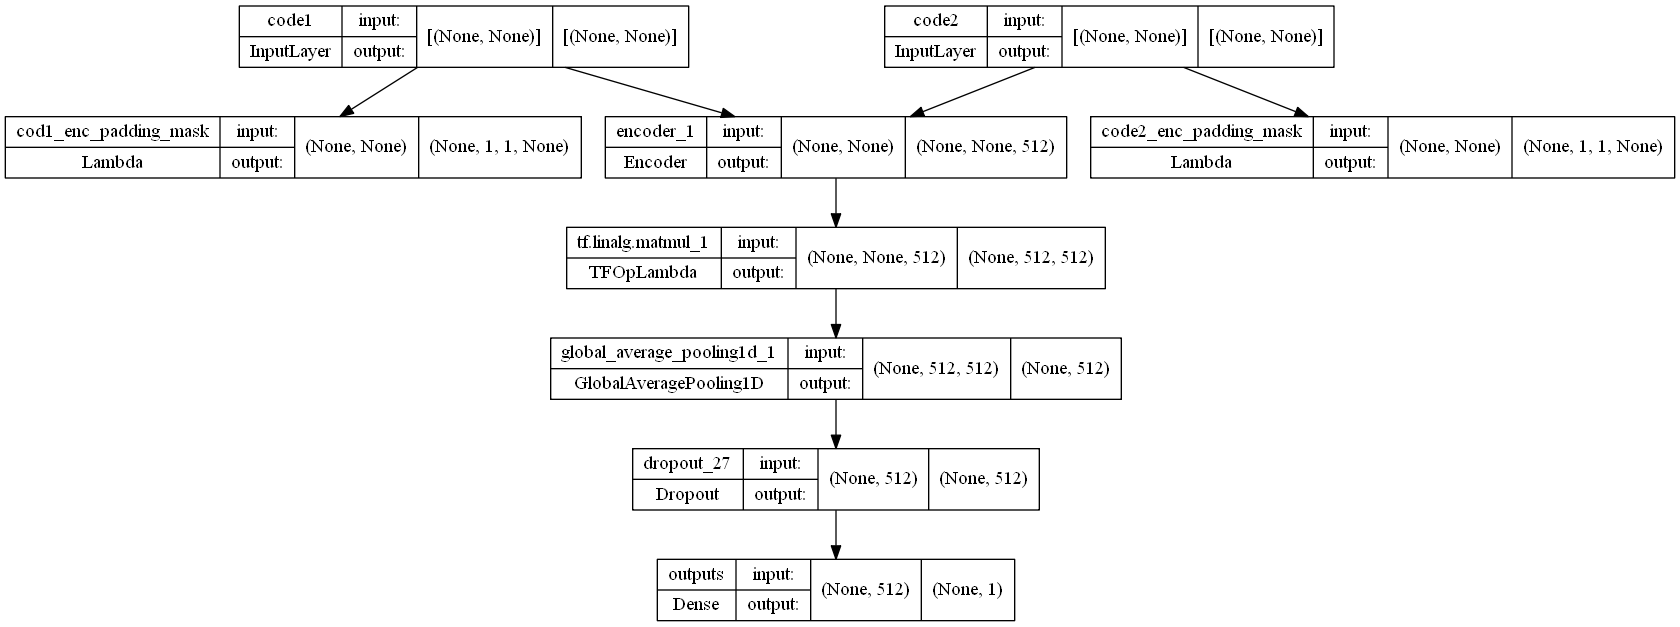

In [46]:
# make_model(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, training=False, rate=0.1):
model = make_model(
  cfg.num_layers,
  cfg.d_model,
  cfg.num_heads,
  cfg.dff,
  cfg.vocab_size,
  cfg.max_len,
)

tf.keras.utils.plot_model(
    model, show_shapes=True
)

In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 code1 (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 code2 (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 cod1_enc_padding_mask (Lambda)  (None, 1, 1, None)  0           ['code1[0][0]']                  
                                                                                                  
 code2_enc_padding_mask (Lambda  (None, 1, 1, None)  0           ['code2[0][0]']                  
 )                                                                                          

In [48]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics='accuracy',
                  )

In [49]:
train_step = len(train_ds)//BATCH_SIZE
val_step = len(val_ds)//BATCH_SIZE

# early stop point
early_stop_point = keras.callbacks.EarlyStopping(patience=50)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
    
# tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)
# with strategy.scope():

# 모델 테스트
filepath = "./model/{epoch:03d}-{val_loss:.4f}.h5"
check_point = keras.callbacks.ModelCheckpoint(
filepath=filepath,
save_best_only = True,
verbose = False
)

hist = model.fit(
    configure_for_performance(train_ds), epochs=1000,
    steps_per_epoch=train_step,
    validation_data=configure_for_performance(val_ds),
    validation_steps=val_step,
    callbacks=[check_point, early_stop_point],
    verbose=1,
)

Virtual devices cannot be modified after being initialized
Epoch 1/1000


InvalidArgumentError: Input 'pred' passed float expected bool while building NodeDef 'model_1/encoder_1/encoder_layer_6/dropout_14/cond/switch_pred/_2' using Op<name=Switch; signature=data:T, pred:bool -> output_false:T, output_true:T; attr=T:type> [Op:__inference_train_function_31417]

In [51]:
model.evaluate(val_ds.take(1))

ValueError: in user code:

    File "c:\Users\Mu-jun\anaconda3\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\Mu-jun\anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Mu-jun\anaconda3\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\Mu-jun\anaconda3\lib\site-packages\keras\engine\training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\Mu-jun\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Mu-jun\AppData\Local\Temp/ipykernel_9044/3043387460.py", line 6, in create_padding_mask
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    ValueError: Exception encountered when calling layer "code2_enc_padding_mask" (type Lambda).
    
    Index out of range using input dim 1; input has only 1 dims for '{{node model_1/code2_enc_padding_mask/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=9, ellipsis_mask=0, end_mask=9, new_axis_mask=6, shrink_axis_mask=0](model_1/code2_enc_padding_mask/Cast, model_1/code2_enc_padding_mask/strided_slice/stack, model_1/code2_enc_padding_mask/strided_slice/stack_1, model_1/code2_enc_padding_mask/strided_slice/stack_2)' with input shapes: [512], [4], [4], [4] and with computed input tensors: input[3] = <1 1 1 1>.
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(512,), dtype=float32)
      • mask=None
      • training=False


In [ ]:

'''
10개의 베스트 모델 만들기

for i in range(10):
  
  filepath = "./model/%03d-best_model.h5"%i
  check_point = keras.callbacks.ModelCheckpoint(
  filepath=filepath,
  save_best_only = True,
  verbose = False
  )
  
  tf.random.set_seed(i)        
  model = make_model()
  model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics='accuracy',
                    )
  
  print(f"{i:03d} fit start")
  hist = model.fit(
      configure_for_performance(train_ds), epochs=1000,
      steps_per_epoch=train_step,
      validation_data=configure_for_performance(val_ds),
      validation_steps=val_step,
      callbacks=[check_point, early_stop_point],
      verbose=0,
  )

  with open(f"./model/{i:03d}.txt",'w',encoding='utf-8') as f:
      f.write("loss,val_loss\n")
      
      for loss, val_loss in zip(hist.history['loss'],hist.history['val_loss']):
          f.write("{:.4f},{:.4f}\n".format(loss,val_loss))
  
  del model
  del hist
  del train_ds
  del val_ds
  
  gc.collect()
  '''